In [7]:
!pip install ffmpeg-python

In [8]:
import ffmpeg

In [9]:
import sys 

In [10]:
import nussl 

In [11]:
musdb = nussl.datasets.MUSDB18(download=True)

In [12]:
from common import data 

In [13]:
data.prepare_musdb('~/.nussl/tutorial/')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.46it/s]


In [14]:
stft_params = nussl.STFTParams(window_length=512, hop_length=128, window_type='sqrt_hann')
fg_path = "~/.nussl/tutorial/train"
train_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=1000, coherent_prob=1.0)

In [15]:
fg_path = "~/.nussl/tutorial/valid"
val_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=500)

fg_path = "~/.nussl/tutorial/test"
test_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=100)

In [16]:
nussl_tfm = nussl.datasets.transforms
tfm = nussl_tfm.Compose([
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])

In [17]:
fg_path = "~/.nussl/tutorial/train"
train_data = data.on_the_fly(stft_params, transform=tfm, fg_path=fg_path, num_mixtures=1000, coherent_prob=1.0)

item = train_data[0]
print("Item from train data")
for key in item:
    print(key, type(item[key]))

fg_path = "~/.nussl/tutorial/valid"
val_data = data.on_the_fly(stft_params, transform=tfm, fg_path=fg_path, num_mixtures=500)

test_tfm = nussl_tfm.Compose([])

fg_path = "~/.nussl/tutorial/test"
test_data = data.on_the_fly(stft_params, transform=test_tfm, fg_path=fg_path, num_mixtures=100)

Item from train data
index <class 'int'>
mix_magnitude <class 'torch.Tensor'>
ideal_binary_mask <class 'torch.Tensor'>
source_magnitudes <class 'torch.Tensor'>


In [18]:
import nussl
import torch
from nussl.datasets import transforms as nussl_tfm
from common.models import MaskInference
from common import utils, data
from pathlib import Path

utils.logger()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MAX_MIXTURES = int(1e8) # We'll set this to some impossibly high number for on the fly mixing.

stft_params = nussl.STFTParams(window_length=512, hop_length=128)

tfm = nussl_tfm.Compose([
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])

train_folder = "~/.nussl/tutorial/train"
val_folder = "~/.nussl/tutorial/valid"

train_data = data.on_the_fly(stft_params, transform=tfm, 
    fg_path=train_folder, num_mixtures=MAX_MIXTURES, coherent_prob=1.0)
train_dataloader = torch.utils.data.DataLoader(
    train_data, num_workers=1, batch_size=10)

val_data = data.on_the_fly(stft_params, transform=tfm, 
    fg_path=val_folder, num_mixtures=10, coherent_prob=1.0)
val_dataloader = torch.utils.data.DataLoader(
    val_data, num_workers=1, batch_size=10)

nf = stft_params.window_length // 2 + 1
model = MaskInference.build(nf, 1, 50, 1, True, 0.0, 4, 'sigmoid')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nussl.ml.train.loss.L1Loss()

def train_step(engine, batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    
    loss.backward() # backwards + gradient step
    optimizer.step()
    
    loss_vals = {
        'L1Loss': loss.item(),
        'loss': loss.item()
    }
    
    return loss_vals

def val_step(engine, batch):
    with torch.no_grad():
        output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )    
    loss_vals = {
        'L1Loss': loss.item(), 
        'loss': loss.item()
    }
    return loss_vals

# Create the engines
trainer, validator = nussl.ml.train.create_train_and_validation_engines(
    train_step, val_step, device=DEVICE
)

# We'll save the output relative to this notebook.
output_folder = Path('.').absolute()

# Adding handlers from nussl that print out details about model training
# run the validation step, and save the models.
nussl.ml.train.add_stdout_handler(trainer, validator)
nussl.ml.train.add_validate_and_checkpoint(output_folder, model, 
    optimizer, train_data, trainer, val_dataloader, validator)

trainer.run(
    train_dataloader, 
    epoch_length=10, 
    max_epochs=5
)

C:\Users\Angel\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([10, 1724, 257, 1, 1])) that is different to the input size (torch.Size([10, 1724, 257, 1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


State:
	iteration: 50
	epoch: 5
	epoch_length: 10
	max_epochs: 5
	output: <class 'dict'>
	batch: <class 'dict'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	epoch_history: <class 'dict'>
	iter_history: <class 'dict'>
	past_iter_history: <class 'dict'>
	saved_model_path: C:\Users\Angel\Documents\School\Senior Project\checkpoints\best.model.pth
	output_folder: <class 'pathlib.WindowsPath'>

In [19]:
from nussl.core.audio_signal import STFTParams
torch.serialization.add_safe_globals([STFTParams])

In [20]:
from nussl.datasets.transforms import Compose
torch.serialization.add_safe_globals([Compose])

In [21]:
from nussl.datasets.transforms import SumSources
torch.serialization.add_safe_globals([SumSources])

In [22]:
from nussl.datasets.transforms import MagnitudeSpectrumApproximation
torch.serialization.add_safe_globals([MagnitudeSpectrumApproximation])

In [23]:
from nussl.datasets.transforms import IndexSources
torch.serialization.add_safe_globals([IndexSources])

In [24]:
from nussl.datasets.transforms import ToSeparationModel
torch.serialization.add_safe_globals([ToSeparationModel])

In [25]:
from numpy.core.multiarray import scalar 
torch.serialization.add_safe_globals([scalar])

In [26]:
from numpy.dtypes import Float64DType
torch.serialization.add_safe_globals([Float64DType])

In [27]:
import numpy as np 
torch.serialization.add_safe_globals([np.dtype])

In [28]:
separator_dme = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path='checkpoints/best.model.pth',
    device=DEVICE,
)

C:\Users\Angel\anaconda3\Lib\site-packages\nussl\separation\base\separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
C:\Users\Angel\anaconda3\Lib\site-packages\nussl\core\audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


In [29]:
tfm = nussl_tfm.Compose([
])
test_dataset = nussl.datasets.MUSDB18(subsets=['test'], transform=tfm)
separator_dme.audio_signal = test_dataset[0]['mix']
separator_dme.run()

In [30]:
import matplotlib.pyplot as plt
def visualize_signals(signals, labels, colors):
    from common import viz 
    fig, axes = plt.subplots()
    t = np.linspace(0, 7, 600064, False)
    index = 0
    for signal in signals:
        plt.plot(t, signal.audio_data.flatten(), color=colors[index], alpha=0.5, label=labels[index])
        index = index + 1
    plt.tight_layout()
    plt.legend()
    plt.show()

In [31]:
audios = separator_dme.make_audio_signals()

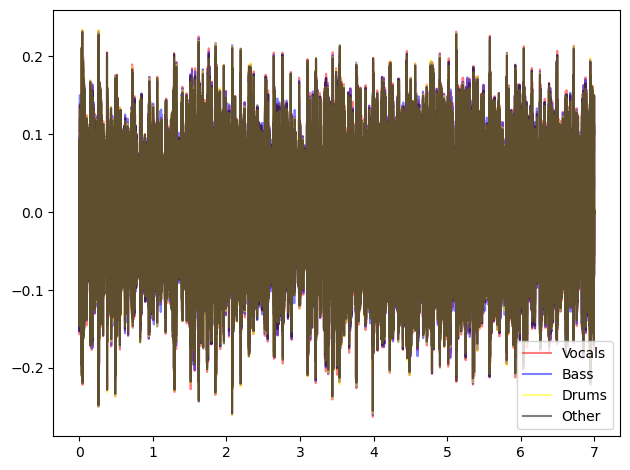

In [32]:
labels = ['Vocals', 'Bass', 'Drums', 'Other']
colors = ['red', 'blue', 'yellow', 'black']
visualize_signals(audios, labels, colors)

In [33]:
import sys
# getting path of file passed in 
if len(sys.argv) > 1 :
    path = sys.argv[1][0]

In [36]:
import nussl
#path = "1_AM Contra - Heart Peripheral.wav"
separator_dme.audio_signal = nussl.AudioSignal(path)
separator_dme.run()

In [38]:
audios = separator_dme.make_audio_signals()
source_names = ['vocals', 'bass', 'drums', 'other']
index = 0
for signal in audios :
    source_output_file = f"{source_names[index]}_{path}"
    signal.write_audio_to_file(str(source_output_file))
    print(f"Saved {source_names[index]} as {source_output_file}")
    index = index + 1

Saved vocals as vocals_1_AM Contra - Heart Peripheral.wav
Saved bass as bass_1_AM Contra - Heart Peripheral.wav
Saved drums as drums_1_AM Contra - Heart Peripheral.wav
Saved other as other_1_AM Contra - Heart Peripheral.wav
